# Experiment result analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
plt.style.use('ggplot')

In [2]:
def parse_thread_results(filename):
    with open(filename, 'r') as file:
        text_content = file.read()

    sections = [
        r'=== (\d+) Threads? per process ===',
        r'=== (\d+) Thread per process ==='
    ]
    results = []
    for section in sections:
        # Find all thread experiment sections
        matches = list(re.finditer(section, text_content))
        for match in matches:
            threads = int(match.group(1))
            start_pos = match.start()
            
            # Find the end of this experiment (next thread experiment or end of file)
            next_match = None
            for next_pattern in sections:
                next_matches = list(re.finditer(next_pattern, text_content[start_pos + 10:]))
                if next_matches:
                    next_match = next_matches[0]
                    break
            
            if next_match:
                end_pos = start_pos + 10 + next_match.start()
                experiment_text = text_content[start_pos:end_pos]
            else:
                experiment_text = text_content[start_pos:]
            
            
            algorithms_patterns = r"Algorithm:\s*([^\n]+)"
            mpi_processes_patterns = r"MPI processes:\s*(\d+)"
            time_patterns = r"Total execution time:\s*([\d.]+)\s*ms"

            algorithms_match = re.search(algorithms_patterns, experiment_text)
            mpi_processes_match = re.search(mpi_processes_patterns, experiment_text)
            time_match = re.search(time_patterns, experiment_text)
            if algorithms_match and mpi_processes_match and time_match:
                result = {
                    'algorithm': algorithms_match.group(1).strip(),
                    'mpi_processes': int(mpi_processes_match.group(1)),
                    'threads': threads,
                    'time(ms)': float(time_match.group(1).strip())
                }
                results.append(result)

    return results

In [3]:
thread_results = parse_thread_results('thread_results.txt')
print(thread_results)

thread_df = pd.DataFrame(thread_results)


[{'algorithm': 'sw', 'mpi_processes': 4, 'threads': 1, 'time(ms)': 1825.0}, {'algorithm': 'sw', 'mpi_processes': 4, 'threads': 2, 'time(ms)': 1506.0}, {'algorithm': 'sw', 'mpi_processes': 4, 'threads': 4, 'time(ms)': 17178.0}, {'algorithm': 'sw', 'mpi_processes': 4, 'threads': 8, 'time(ms)': 233605.0}, {'algorithm': 'sw', 'mpi_processes': 4, 'threads': 1, 'time(ms)': 1825.0}]


In [4]:
thread_df

,algorithm,mpi_processes,threads,time(ms)
0,sw,4,1,1825.0
1,sw,4,2,1506.0
2,sw,4,4,17178.0
3,sw,4,8,233605.0
4,sw,4,1,1825.0


In [5]:
def parse_scaling_results(filename):
    with open(filename, 'r') as file:
        text_content = file.read()

    sections = [
        r'=== (\d+) Process ===',
        r'=== (\d+) Processes ==='
    ]
    results = []
    for section in sections:
        # Find all  experiment sections
        matches = list(re.finditer(section, text_content))
        for match in matches:
            start_pos = match.start()

            # Find the end of this experiment (next process experiment or end of file)
            next_match = None
            for next_pattern in sections:
                next_matches = list(re.finditer(next_pattern, text_content[start_pos + 10:]))
                if next_matches:
                    next_match = next_matches[0]
                    break
            
            if next_match:
                end_pos = start_pos + 10 + next_match.start()
                text = text_content[start_pos:end_pos]
            else:
                text = text_content[start_pos:]
                
            # Split by algorithm sections
            simple_start = text.find('Simple Algorithm:')
            sw_start = text.find('Smith-Waterman Algorithm:')
            
            # Process Simple Algorithm
            if simple_start != -1:
                # Get text from Simple Algorithm start to Smith-Waterman start (or end)
                if sw_start != -1:
                    simple_text = text[simple_start:sw_start]
                else:
                    simple_text = text[simple_start:]
                
                # Extract data for Simple Algorithm
                mpi_match = re.search(r'MPI Processes:\s*(\d+)', simple_text)
                threads_match = re.search(r'OpenMP Threads per process:\s*(\d+)', simple_text)
                time_match = re.search(r'Total execution time:\s*(\d+)\s*ms', simple_text)
                
                if mpi_match and threads_match and time_match:
                    result = {
                        'algorithm': 'Simple Sliding Window',
                        'mpi_processes': int(mpi_match.group(1)),
                        'openmp_threads': int(threads_match.group(1)),
                        'time_ms': int(time_match.group(1))
                    }
                    results.append(result)
                    print(f"Simple: MPI={result['mpi_processes']}, Threads={result['openmp_threads']}, Time={result['time_ms']}ms")
            
            # Process Smith-Waterman Algorithm
            if sw_start != -1:
                sw_text = text[sw_start:]
                
                # Extract data for Smith-Waterman Algorithm
                mpi_match = re.search(r'MPI Processes:\s*(\d+)', sw_text)
                threads_match = re.search(r'OpenMP Threads per process:\s*(\d+)', sw_text)
                time_match = re.search(r'Total execution time:\s*(\d+)\s*ms', sw_text)
                
                if mpi_match and threads_match and time_match:
                    result = {
                        'algorithm': 'Smith-Waterman Local Alignment',
                        'mpi_processes': int(mpi_match.group(1)),
                        'openmp_threads': int(threads_match.group(1)),
                        'time_ms': int(time_match.group(1))
                    }
                    results.append(result)
                    print(f"Smith-Waterman: MPI={result['mpi_processes']}, Threads={result['openmp_threads']}, Time={result['time_ms']}ms")
            
    return results

In [6]:
scaling_result = parse_scaling_results('scaling_results.txt')
scaling_result_df = pd.DataFrame(scaling_result)
scaling_result_df

Simple: MPI=2, Threads=2, Time=20ms
Smith-Waterman: MPI=2, Threads=2, Time=2873ms
Simple: MPI=4, Threads=2, Time=64ms
Smith-Waterman: MPI=4, Threads=2, Time=1426ms
Simple: MPI=8, Threads=2, Time=109ms
Smith-Waterman: MPI=8, Threads=2, Time=1833ms


,algorithm,mpi_processes,openmp_threads,time_ms
0,Simple Sliding Window,2,2,20
1,Smith-Waterman Local Alignment,2,2,2873
2,Simple Sliding Window,4,2,64
3,Smith-Waterman Local Alignment,4,2,1426
4,Simple Sliding Window,8,2,109
5,Smith-Waterman Local Alignment,8,2,1833


In [7]:
def parse_algorithm_results(filename):
    with open(filename, 'r') as file:
        text_content = file.read()

    sections = [
        r'=== ([^\n]+) ?Algorithm ==='
    ]
    results = []
    for section in sections:
        # Find all thread experiment sections
        matches = list(re.finditer(section, text_content))
        for match in matches:
            start_pos = match.start()
            
            # Find the end of this experiment (next thread experiment or end of file)
            next_match = None
            for next_pattern in sections:
                next_matches = list(re.finditer(next_pattern, text_content[start_pos + 10:]))
                if next_matches:
                    next_match = next_matches[0]
                    break
            
            if next_match:
                end_pos = start_pos + 10 + next_match.start()
                experiment_text = text_content[start_pos:end_pos]
            else:
                experiment_text = text_content[start_pos:]
            
            
            algorithms_patterns = r"=== ([^\n]+) ?Algorithm ==="
            mpi_processes_patterns = r"MPI processes:\s*(\d+)"
            threads_patterns = r"OpenMP threads per process:\s*(\d+)"
            time_patterns = r"Total execution time:\s*([\d.]+)\s*ms"

            algorithms_match = re.search(algorithms_patterns, experiment_text)
            mpi_processes_match = re.search(mpi_processes_patterns, experiment_text)
            threads_match = re.search(threads_patterns, experiment_text)
            time_match = re.search(time_patterns, experiment_text)
            if algorithms_match and mpi_processes_match and time_match:
                result = {
                    'algorithm': algorithms_match.group(1).strip(),
                    'mpi_processes': int(mpi_processes_match.group(1)),
                    'threads': int(threads_match.group(1)),
                    'time(ms)': float(time_match.group(1).strip())
                }
                results.append(result)

    return results

In [8]:
algorithm_result = parse_algorithm_results('algorithm_results.txt')
algorithm_result_df = pd.DataFrame(algorithm_result)
algorithm_result_df

,algorithm,mpi_processes,threads,time(ms)
0,Simple Sliding Window,4,2,25.0
1,Smith-Waterman,4,2,1435.0


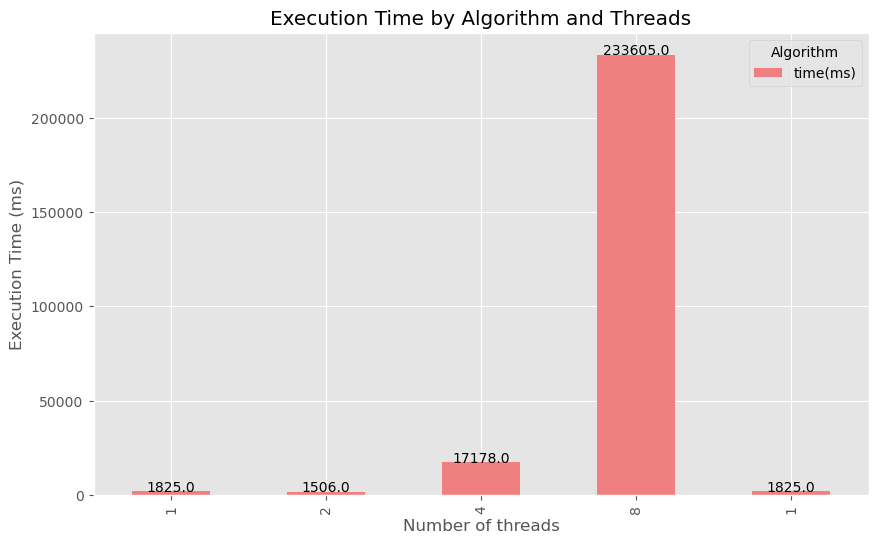

In [9]:
# Plotting
thread_df.plot(x='threads', y='time(ms)', kind='bar', color='lightcoral', figsize=(10, 6))
plt.title('Execution Time by Algorithm and Threads')
plt.xlabel('Number of threads')
plt.ylabel('Execution Time (ms)')
plt.legend(title='Algorithm')
plt.grid(True)
# Text to show exact values on bars
for i, row in thread_df.iterrows():
    plt.text(i, row['time(ms)'] + 5, f"{row['time(ms)']:.1f}", ha='center')

plt.show()

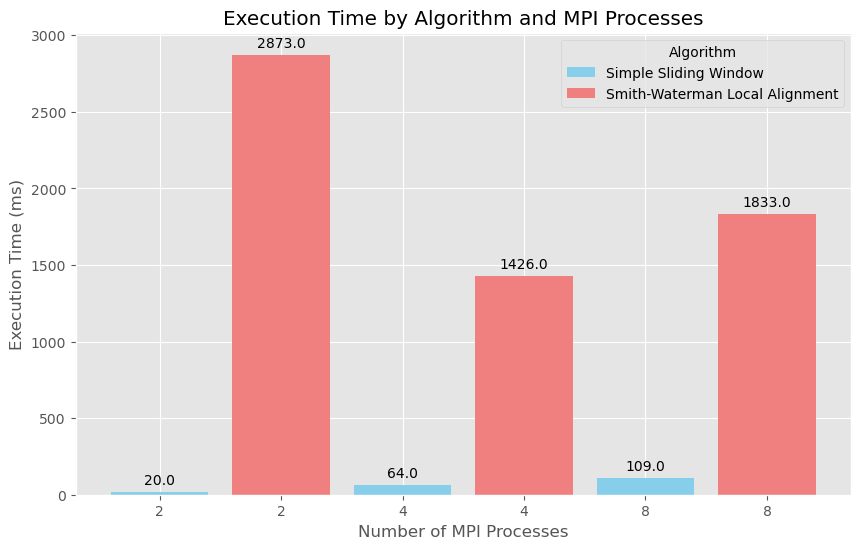

In [10]:
# Plot result for scaling results
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each algorithm
colors = {'Simple Sliding Window': 'skyblue', 
          'Smith-Waterman Local Alignment': 'lightcoral'}

# Create the bar plot with colors based on algorithm
bars = ax.bar(range(len(scaling_result_df)), 
              scaling_result_df['time_ms'],
              color=[colors[algo] for algo in scaling_result_df['algorithm']])

# Set x-axis labels
ax.set_xticks(range(len(scaling_result_df)))
ax.set_xticklabels(scaling_result_df['mpi_processes'])

plt.title('Execution Time by Algorithm and MPI Processes')
plt.xlabel('Number of MPI Processes')
plt.ylabel('Execution Time (ms)')
plt.grid(True)

# Add value labels on bars
for i, (idx, row) in enumerate(scaling_result_df.iterrows()):
    plt.text(i, row['time_ms'] + 50, f"{row['time_ms']:.1f}", ha='center')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[algo], label=algo) 
                   for algo in colors.keys()]
plt.legend(handles=legend_elements, title='Algorithm')

plt.show()

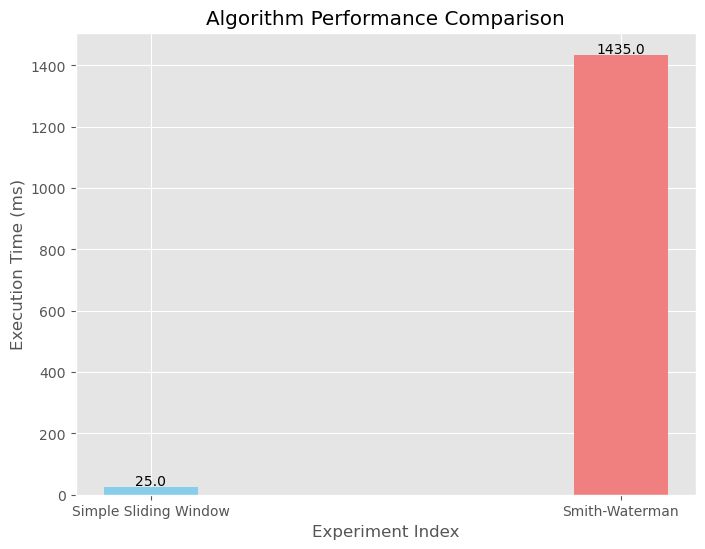

In [11]:
# Plot with custom bar width
fig, ax = plt.subplots(figsize=(8, 6))
# Define colors for each algorithm
colors = {'Simple Sliding Window': 'skyblue',
          'Smith-Waterman': 'lightcoral'}

# Plot bars with custom width
bar_width = 0.2  # Default is 0.8
ax.bar(algorithm_result_df.index, algorithm_result_df['time(ms)'], 
       color=[colors[alg] for alg in algorithm_result_df['algorithm']], width=bar_width)

plt.title('Algorithm Performance Comparison')
plt.xlabel('Experiment Index')
plt.ylabel('Execution Time (ms)')
# Add value labels on bars
for i, (idx, row) in enumerate(algorithm_result_df.iterrows()):
    plt.text(i, row['time(ms)'] + 5, f"{row['time(ms)']:.1f}", ha='center')
plt.xticks(ticks=range(len(algorithm_result_df)), labels=algorithm_result_df['algorithm'])
plt.grid(True)
plt.show()
